In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
from datetime import datetime
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os
import glob
from PIL import Image
from scipy import stats
from straxen import units
from scipy.optimize import curve_fit
from datetime import datetime, timedelta

Start import
Working on midway2-0462.rcc.local with the following versions 
and installation paths:
strax
	v1.2.0	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/strax
straxen
	v1.6.0	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [3]:
dsets = st.select_runs(exclude_tags=('bad','messy'), run_mode='tpc_kr*',
                       available=('event_info','peak_basics'))

Checking data availability:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dsets = dsets[(dsets.number >= 41436) & (dsets.livetime>np.timedelta64(30,'m'))]

In [3]:
#Kr_runs = np.array(dsets['name'])
Kr_runs = ['041481', '041478', '041475', '041472', '041469', '041466',
       '041463', '041460', '041457', '041454', '041451', '041448',
       '041445', '041442', '041439', '041436']

In [4]:
def mask_KrSingleS1(df):
    def line(x):
        return 0.55 * x + 15
    mask = (df['ds_s1_dt'] == 0)
    mask &= (df['s1_a_n_channels'] >= 90) & (df['s1_a_n_channels'] < 225)
    mask &= (line(df['s1_a_area']) > df['s1_a_n_channels'])
    mask &= (df['s1_a_range_50p_area'] >= 60) & (df['s1_a_range_50p_area'] < 1000)
    mask &= (df['s1_a_area_fraction_top'] < 0.68)
    return mask

In [12]:
def plot_area_width_aft_Kr(run_id, low = 0, high = 7, low2 = 0, high2 = 1, binning = 500,plot=False):
    events0 = st.get_df(run_id,'event_info_double',progress_bar=False)
    mask = mask_KrSingleS1(events0)
    livetime = (events0['time'][len(events0)-1]-events0['time'][0])/1e9
    events = events0[mask]
    ph_s1 = Histdd(events['s1_a_area'], events['s1_a_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    ph_s2 = Histdd(events['s2_a_area'], events['s2_a_range_50p_area'],
                    bins=(np.logspace(low, high, binning), np.logspace(1, 6, binning)))
    phcs1 = Histdd(events['s1_a_area'], events['s1_a_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    phcs2 = Histdd(events['s2_a_area'], events['s2_a_area_fraction_top'],
                    bins=(np.logspace(low, high, binning), np.linspace(0, 1, binning)))
    kr_rate = len(events)/livetime
    all_rate = len(events0)/livetime
    kr_rates, all_rates, slot_times = [], [], []
    for i in range(10):
        idx1, idx2 = int(i*(len(events0)-1)/10), int((i+1)*(len(events0)-1)/10)
        slot_time = (events0['time'][idx2]-events0['time'][idx1])/1e9
        trange = (events0['time']>events0['time'][idx1]) & (events0['time']<events0['time'][idx2])
        kr_rates = np.append(kr_rates,len(events0[mask & trange])/slot_time)
        all_rates = np.append(all_rates,len(events0[trange])/slot_time)
        timestamp = events0['time'][idx1]/1e9
        slot_times = np.append(slot_times,datetime.fromtimestamp(timestamp))
    if plot:
        plt.figure(figsize=(12,6))
        ph_s1.plot(log_scale=True, cblabel='S1 events')#,cmap='plasma')
        #phcs2.plot(log_scale=True, cblabel='S2 events')
        plt.xlabel("peak area (PE)", ha='right', x=1)
        plt.ylabel("area fraction top", ha='right', y=1)
        plt.title(f'run {run_id}')
        plt.xscale('log')
        plt.title(f'run {run_id} - Kr-rate: {kr_rate:.2f} Hz')
        plt.savefig(f'area_vs_aft_run{run_id}.png')
        """
        plt.figure(figsize=(12,6))
        ph_s1.plot(log_scale=True, cblabel='S1 events',cmap='plasma')
        ph_s2.plot(log_scale=True, cblabel='S2 events')
        plt.xlabel("peak area (PE)", ha='right', x=1)
        plt.ylabel("peak width 50% (ns)", ha='right', y=1)
        plt.title(f'run {run_id} - Kr-rate: {kr_rate:.2f} Hz')
        plt.xscale('log')
        plt.yscale('log')
               
        plt.figure(figsize=(12,6))
        ph_s1s2 = Histdd(events['s1_a_area'], events['s2_a_area'],
                        bins=(np.logspace(0, 5, binning), np.logspace(1, 7, binning)))
        ph_s1s2.plot(log_scale=True, cblabel='S2 events')
        plt.xlabel("S1 peak area (PE)", ha='right', x=1)
        plt.ylabel("S2 peak area (PE)", ha='right', y=1)
        plt.title(f'run {run_id} - Kr-rate: {kr_rate:.2f} Hz')
        plt.xscale('log')
        plt.yscale('log')
        """
    print(f'run {run_id}, livetime {livetime:.2f} s, Kr-rate: {kr_rate:.2f} Hz')
    return kr_rate, all_rate, kr_rates, all_rates, slot_times

In [13]:
kr, aa, krs, ass, ss = plot_area_width_aft_Kr(Kr_runs[1],plot=1)

ValueError: Invalid vmin or vmax

ValueError: Invalid vmin or vmax

<Figure size 864x432 with 2 Axes>

In [9]:
def plots_area_vs_aft(runs,gif=False):
    kr_rates, all_rates, slot_times, tot_kr_rates, tot_all_rates = [], [], [], [], []
    for i, run in enumerate(runs):
        kr_rate, all_rate, krs, alls, slots = plot_area_width_aft_Kr(run,plot=0)
        slot_times = np.append(slot_times,slots)
        kr_rates = np.append(kr_rates,krs)
        all_rates = np.append(all_rates,alls)
        tot_kr_rates = np.append(tot_kr_rates,kr_rate)
        tot_all_rates = np.append(tot_all_rates,all_rate)
    if gif:
        fp_in = f'area_vs_aft_run*.png'
        fp_out = f'area_vs_aft_run{runs[0]}-{runs[-1]}.gif'
        img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
        img.save(fp=fp_out, format='GIF', append_images=imgs,
                 save_all=True, duration=500, loop=0)
        for i, run in enumerate(runs):
            os.remove(f'area_vs_aft_run{run}.png')
    return kr_rates, all_rates, slot_times, tot_kr_rates, tot_all_rates

In [76]:
def plot_kr_rate_vs_time(kr_runs,kr_rates,all_rates,slot_times):
    plt.figure(figsize=(12,6))
    dates = matplotlib.dates.date2num(slot_times + timedelta(hours=7))
    plt.plot_date(dates, kr_rates,'o',label='Kr-83m rate')
    plt.plot_date(dates, all_rates,'o',label='total rate')
    #plt.axvline(x = dates[22],color='black', linestyle = '--',label=f'valve at 0.2 turns')
    #plt.axvline(x = dates[52],color='m', linestyle = '--',label=f'valve at 0.4 turns')
    #plt.axvline(x = dates[83],color='b', linestyle = '--',label=f'valve at 0.8 turns')
    #plt.axvline(x = dates[130],color='r', linestyle = '--',label=f'valve at 3.2 turns')
    myFmt = matplotlib.dates.DateFormatter('%d%bH%H')
    plt.gca().xaxis.set_major_formatter(myFmt)
    plt.title(f'runs {kr_runs[-1]} - {kr_runs[0]}')
    plt.xlabel("LNGS time", ha='right', x=1,fontsize=12)
    plt.ylabel("Kr rate (Hz)", ha='right', y=1,fontsize=12)
    plt.legend(fontsize=14)

run 018294, livetime 1802.73 s, Kr-rate: 17.32 Hz
run 018292, livetime 1801.04 s, Kr-rate: 17.77 Hz
run 018289, livetime 1802.87 s, Kr-rate: 17.84 Hz
run 018287, livetime 1802.49 s, Kr-rate: 17.96 Hz
run 018285, livetime 1801.82 s, Kr-rate: 18.05 Hz
run 018283, livetime 1802.18 s, Kr-rate: 17.77 Hz
run 018279, livetime 1801.71 s, Kr-rate: 17.95 Hz
run 018277, livetime 1800.86 s, Kr-rate: 18.09 Hz
run 018275, livetime 1801.39 s, Kr-rate: 18.00 Hz
run 018273, livetime 1802.72 s, Kr-rate: 17.96 Hz
run 018271, livetime 1801.91 s, Kr-rate: 18.26 Hz
run 018269, livetime 1802.77 s, Kr-rate: 18.03 Hz
run 018267, livetime 1803.43 s, Kr-rate: 18.10 Hz
run 018265, livetime 1803.47 s, Kr-rate: 18.06 Hz
run 018263, livetime 1801.14 s, Kr-rate: 18.12 Hz
run 018261, livetime 1802.39 s, Kr-rate: 18.08 Hz
run 018259, livetime 1801.81 s, Kr-rate: 18.10 Hz
run 018257, livetime 1800.32 s, Kr-rate: 18.36 Hz
run 018255, livetime 1801.15 s, Kr-rate: 18.33 Hz
run 018253, livetime 1802.44 s, Kr-rate: 18.03 Hz


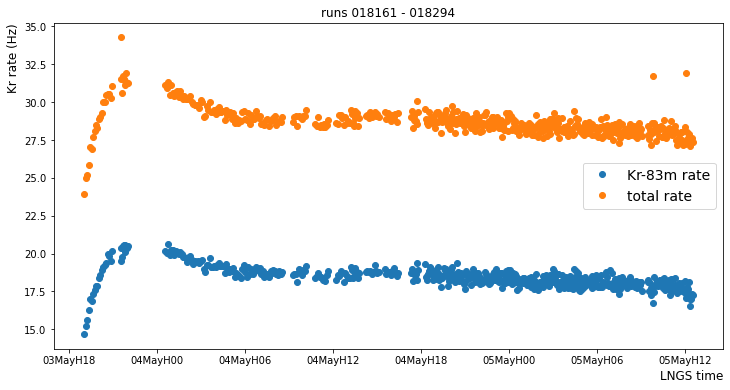

In [77]:
kr_rates, all_rates, slot_times, tot_kr_rates, tot_all_rates = plots_area_vs_aft(runs=Kr_runs1)
plot_kr_rate_vs_time(Kr_runs1,kr_rates,all_rates,slot_times)

run 018420, livetime 1802.22 s, Kr-rate: 28.30 Hz
run 018419, livetime 1803.13 s, Kr-rate: 19.03 Hz
run 018415, livetime 1801.15 s, Kr-rate: 12.97 Hz
run 018414, livetime 1801.51 s, Kr-rate: 11.37 Hz
run 018411, livetime 1802.09 s, Kr-rate: 11.69 Hz
run 018406, livetime 1801.75 s, Kr-rate: 12.30 Hz
run 018404, livetime 1801.10 s, Kr-rate: 12.54 Hz
run 018398, livetime 1801.30 s, Kr-rate: 12.94 Hz
run 018396, livetime 1801.84 s, Kr-rate: 13.26 Hz
run 018394, livetime 1799.99 s, Kr-rate: 13.14 Hz
run 018390, livetime 1800.61 s, Kr-rate: 13.21 Hz
run 018388, livetime 1802.70 s, Kr-rate: 13.27 Hz
run 018386, livetime 1803.28 s, Kr-rate: 13.13 Hz
run 018384, livetime 1800.41 s, Kr-rate: 13.23 Hz
run 018382, livetime 1800.02 s, Kr-rate: 13.14 Hz
run 018380, livetime 1801.64 s, Kr-rate: 13.22 Hz
run 018378, livetime 1802.92 s, Kr-rate: 13.18 Hz
run 018376, livetime 1803.46 s, Kr-rate: 13.25 Hz
run 018374, livetime 1801.67 s, Kr-rate: 13.06 Hz
run 018372, livetime 1802.88 s, Kr-rate: 13.25 Hz


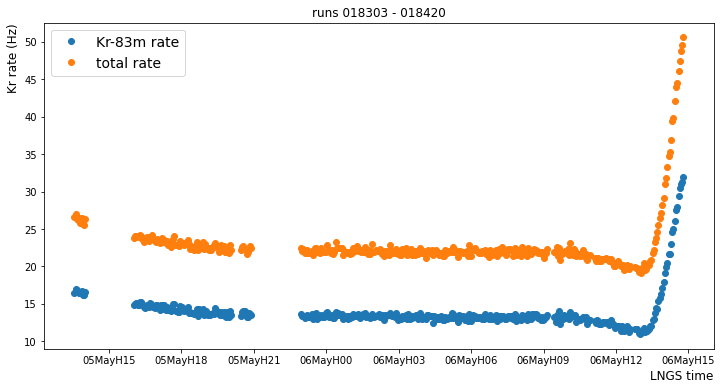

In [78]:
kr_rates, all_rates, slot_times, tot_kr_rates, tot_all_rates = plots_area_vs_aft(runs=Kr_runs2)
plot_kr_rate_vs_time(Kr_runs2,kr_rates,all_rates,slot_times)

run 018871, livetime 1800.91 s, Kr-rate: 45.82 Hz
run 018869, livetime 1801.28 s, Kr-rate: 45.76 Hz
run 018867, livetime 1800.95 s, Kr-rate: 45.70 Hz
run 018865, livetime 1802.10 s, Kr-rate: 45.46 Hz
run 018863, livetime 1801.58 s, Kr-rate: 45.71 Hz
run 018861, livetime 1801.61 s, Kr-rate: 46.10 Hz
run 018859, livetime 1801.11 s, Kr-rate: 45.73 Hz
run 018856, livetime 1803.33 s, Kr-rate: 46.00 Hz
run 018855, livetime 1801.83 s, Kr-rate: 45.66 Hz
run 018852, livetime 1803.19 s, Kr-rate: 45.76 Hz
run 018851, livetime 1801.76 s, Kr-rate: 45.55 Hz
run 018848, livetime 1802.49 s, Kr-rate: 45.50 Hz
run 018847, livetime 1801.46 s, Kr-rate: 45.74 Hz
run 018844, livetime 1803.43 s, Kr-rate: 45.69 Hz
run 018843, livetime 1801.25 s, Kr-rate: 45.68 Hz
run 018838, livetime 1800.42 s, Kr-rate: 45.51 Hz
run 018836, livetime 1802.59 s, Kr-rate: 45.76 Hz
run 018834, livetime 1802.95 s, Kr-rate: 45.82 Hz
run 018832, livetime 1800.27 s, Kr-rate: 45.94 Hz
run 018830, livetime 1800.07 s, Kr-rate: 45.73 Hz


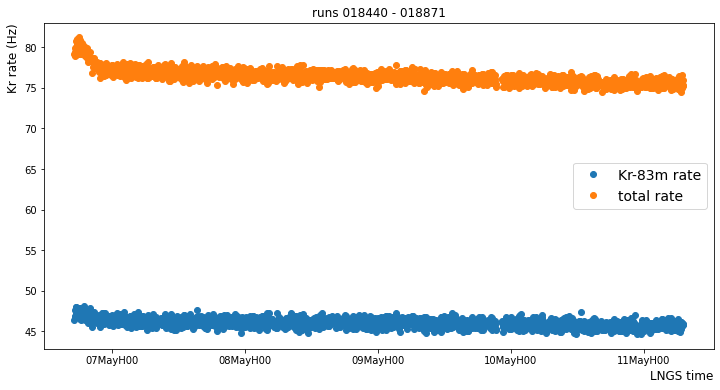

In [93]:
#'018840','018812',018439
kr_rates, all_rates, slot_times, tot_kr_rates, tot_all_rates = plots_area_vs_aft(runs=Kr_runs3)
plot_kr_rate_vs_time(Kr_runs3,kr_rates,all_rates,slot_times)

run 018981, livetime 1800.19 s, Kr-rate: 47.53 Hz
run 018978, livetime 1802.23 s, Kr-rate: 47.17 Hz
run 018975, livetime 1802.99 s, Kr-rate: 45.86 Hz
run 018973, livetime 1801.11 s, Kr-rate: 45.82 Hz
run 018971, livetime 1801.30 s, Kr-rate: 45.42 Hz
run 018969, livetime 1803.22 s, Kr-rate: 45.62 Hz
run 018967, livetime 1800.81 s, Kr-rate: 45.66 Hz
run 018965, livetime 1803.36 s, Kr-rate: 45.68 Hz
run 018963, livetime 1803.37 s, Kr-rate: 45.91 Hz
run 018961, livetime 1803.30 s, Kr-rate: 45.94 Hz
run 018959, livetime 1802.92 s, Kr-rate: 45.66 Hz
run 018957, livetime 1802.02 s, Kr-rate: 45.73 Hz
run 018955, livetime 1802.76 s, Kr-rate: 45.67 Hz
run 018953, livetime 1802.66 s, Kr-rate: 45.71 Hz
run 018951, livetime 1803.38 s, Kr-rate: 45.67 Hz
run 018949, livetime 1802.78 s, Kr-rate: 45.73 Hz
run 018947, livetime 1800.64 s, Kr-rate: 45.72 Hz
run 018945, livetime 1803.25 s, Kr-rate: 45.60 Hz
run 018943, livetime 1801.39 s, Kr-rate: 45.82 Hz
run 018941, livetime 1801.51 s, Kr-rate: 45.82 Hz


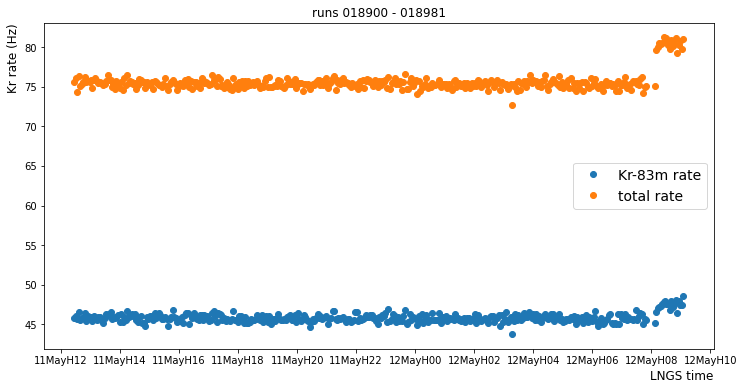

In [94]:
kr_rates, all_rates, slot_times, tot_kr_rates, tot_all_rates = plots_area_vs_aft(runs=Kr_runs4)
plot_kr_rate_vs_time(Kr_runs4,kr_rates,all_rates,slot_times)